In [1]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 KB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 10.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=3923272b066b889e01a4624e5463f4a811f1576252704a39384f45be26b5613f
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import datetime
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()


--2023-03-28 21:09:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.128, 142.251.31.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.4MB/s    in 4.7s    

2023-03-28 21:09:33 (34.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in \'{dirpath}\'')

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as idg

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

image_datagen = idg(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True)

print('Training Images')
train_data_10_percent = image_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True
)

print('Testing Images')

test_data_10_percent = image_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode= 'categorical',
    shuffle = True
)

Training Images
Found 750 images belonging to 10 classes.
Testing Images
Found 2500 images belonging to 10 classes.


In [6]:
import pathlib
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

Image Shape: (512, 512, 3)


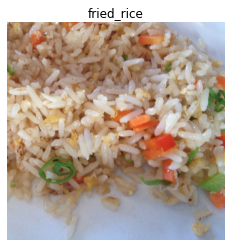

In [7]:
import matplotlib.image as mpimg
import random

def view_random(target_dir, target_class):
  target_folder = target_dir+target_class
  rand_image = random.sample(os.listdir(target_folder),1)
  img = mpimg.imread(target_folder+'/'+rand_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image Shape: {img.shape}')

def plot_history(history_name):
  model_history = pd.DataFrame(history_name.history)
  model_history.plot(figsize=(11,8), title = 'Model_Performance', xlabel = 'epochs', ylabel = 'performance')

view_random(train_dir+'/', random.choice(class_names))

In [8]:
import tensorflow_hub as hub
def createModel(model_url, num_classes = len(class_names)):
  feature_extractor_layer = hub.KerasLayer(model_url, trainable= False, name= 'feature_extraction_layer', input_shape = IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')
  ])
  return model


In [9]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="mobile-net",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 1280,
        "activation_1": "relu",
        "layer_2": len(class_names),
        "activation_2": "softmax",
        "optimizer": "adam",
        "loss": "categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 8,
        "batch_size": len(train_data_10_percent)
    }
)
config = wandb.config

mobileNet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
mobilenet_model = createModel(mobileNet_url)
mobilenet_model.compile(optimizer=config.optimizer,
              loss=config.loss,
              metrics=[config.metric])

mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                  epochs = config.epoch,
                                  steps_per_epoch = len(train_data_10_percent),
                                  validation_data = test_data_10_percent,
                                  validation_steps= len(test_data_10_percent),
                                  callbacks=[WandbMetricsLogger(log_freq=5), WandbModelCheckpoint("models")])
wandb.finish()

wandb: Currently logged in as: saikrishna-v1970 (tensorflow_certi). Use `wandb login --relogin` to force relogin


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/8
24/24 [==============================] - ETA: 0s - loss: 1.9307 - accuracy: 0.3573

wandb: Adding directory to artifact (./models)... Done. 0.0s


24/24 [==============================] - 80s 3s/step - loss: 1.9307 - accuracy: 0.3573 - val_loss: 1.4372 - val_accuracy: 0.5524
Epoch 2/8
24/24 [==============================] - ETA: 0s - loss: 1.2291 - accuracy: 0.6440

wandb: Adding directory to artifact (./models)... Done. 0.0s


24/24 [==============================] - 56s 2s/step - loss: 1.2291 - accuracy: 0.6440 - val_loss: 1.0322 - val_accuracy: 0.6896
Epoch 3/8
24/24 [==============================] - ETA: 0s - loss: 0.9101 - accuracy: 0.7200

wandb: Adding directory to artifact (./models)... Done. 0.0s


24/24 [==============================] - 55s 2s/step - loss: 0.9101 - accuracy: 0.7200 - val_loss: 0.8950 - val_accuracy: 0.7216
Epoch 4/8
24/24 [==============================] - ETA: 0s - loss: 0.7832 - accuracy: 0.7747

wandb: Adding directory to artifact (./models)... Done. 0.0s


24/24 [==============================] - 58s 2s/step - loss: 0.7832 - accuracy: 0.7747 - val_loss: 0.8037 - val_accuracy: 0.7548
Epoch 5/8
24/24 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.7933

wandb: Adding directory to artifact (./models)... Done. 0.0s


24/24 [==============================] - 55s 2s/step - loss: 0.6891 - accuracy: 0.7933 - val_loss: 0.7819 - val_accuracy: 0.7520
Epoch 6/8
24/24 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.8067

wandb: Adding directory to artifact (./models)... Done. 0.0s


24/24 [==============================] - 55s 2s/step - loss: 0.6276 - accuracy: 0.8067 - val_loss: 0.6989 - val_accuracy: 0.7860
Epoch 7/8
24/24 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.8253

wandb: Adding directory to artifact (./models)... Done. 0.0s


24/24 [==============================] - 56s 2s/step - loss: 0.5635 - accuracy: 0.8253 - val_loss: 0.6883 - val_accuracy: 0.7936
Epoch 8/8
24/24 [==============================] - ETA: 0s - loss: 0.5197 - accuracy: 0.8560

wandb: Adding directory to artifact (./models)... Done. 0.0s


24/24 [==============================] - 58s 3s/step - loss: 0.5197 - accuracy: 0.8560 - val_loss: 0.6704 - val_accuracy: 0.7924


batch/accuracy,▁▁▂▂▃▅▅▅▅▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇███
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▇▇▅▄▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▂▂▂▂▂▂
epoch/accuracy,▁▅▆▇▇▇██
epoch/epoch,▁▂▃▄▅▆▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▁▁
epoch/val_accuracy,▁▅▆▇▇███
epoch/val_loss,█▄▃▂▂▁▁▁
batch/accuracy,0.85321
